# Using the Deep Q-Learning (DQN) Algorithm For Stock Trading




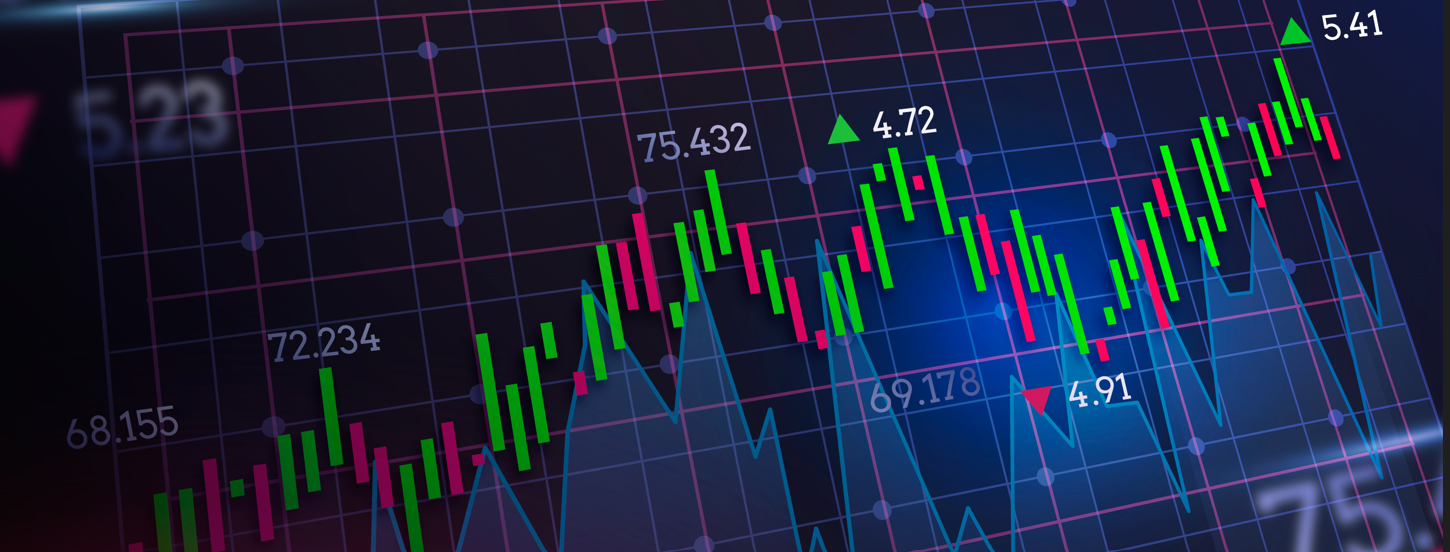











This code block imports necessary libraries and packages for implementing and training the DQN algorithm for trading. It includes modules for data processing, reinforcement learning (RL), and plotting, as well as the DQN algorithm from stable-baselines3.

In [ ]:
# Processing libraries
import os
from typing import Callable
import random
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

# RL libraries and packages
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, BaseCallback
from stable_baselines3 import DQN

This code block changes the current directory to "D:", fetches trading data from the CSV file named "AAPLRobust.csv," and loads it into a Pandas DataFrame named "RS_data." It then displays the first few rows of the data, its info (data types, non-null values, etc.), and the shape (number of rows and columns) of the DataFrame.

In [ ]:
%cd D:\ 
# Fetching trading data
# Loading Robust scaled data
RS_data = pd.read_csv('AAPLRobust.csv')  
RS_data.head()
RS_data.info()
RS_data.shape


This code defines a function linear_schedule that returns a learning rate schedule. The function takes an initial_value, which is the starting learning rate, and returns another function func.

The returned function func takes a single argument progress_remaining, which represents the remaining progress of the learning process (decreases from 1 at the beginning to 0 at the end of training). The func then calculates the current learning rate by multiplying progress_remaining with the initial_value.

In [ ]:
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

This code block defines a custom Gym environment for trading called MyCustomEnv. It extends the StocksEnv class provided by the gym_anytrading library. The custom environment aims to properly format the data frame to be passed through the environment.

signals(env): This function takes an environment env as input and extracts the required price and signal features data from the data frame (env.df) based on the specified frame bounds and window size of the environment. The prices are extracted from the 'Close' column, while the signal features (e.g., volume, log return, moving average volume, RSI, stochastic oscillator, MACD, ATR) are extracted from their respective columns.

MyCustomEnv(StocksEnv): This class inherits from the StocksEnv class. The _process_data class variable is set to the previously defined signals function, which ensures that the custom data processing is used during the environment initialization.

The constructor __init__(self, *args, **kwargs): This initializes the custom environment, and it also initializes variables to keep track of the episode's total reward (self.episode_reward) and episode length (self.episode_length).

step(self, action): This method is overridden to keep track of the episode reward and length. It calls the parent step method of the StocksEnv class to perform the action in the environment and receive the observation (obs), reward (reward), done flag (done), and additional info (info). After each step, the reward is added to the self.episode_reward, and the episode length is incremented. When the episode is done, the episode reward and length are added to the info dictionary, and the episode reward and length variables are reset to start a new episode. Finally, it returns the updated observation, reward, done flag, and info.

Overall, this custom environment is designed to use the custom data processing defined in the signals function and to keep track of the episode reward and length during the training process.

In [ ]:
# Building Gym
# Create a function to properly format the data frame to be passed through the environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Volume', 'LogRet', 'mavol', 'rsi', 'stoch', 'macd', 'atr']].to_numpy()[start:end]
    return prices, signal_features


class MyCustomEnv(StocksEnv):
    _process_data = signals
    
    def __init__(self, *args, **kwargs):
        super(MyCustomEnv, self).__init__(*args, **kwargs)
        self.episode_reward = 0.0
        self.episode_length = 0

    def step(self, action):
        obs, reward, done, info = super().step(action)
        self.episode_reward += reward
        self.episode_length += 1
        if done:
            info['episode_reward'] = self.episode_reward
            info['episode_length'] = self.episode_length
            self.episode_reward = 0.0
            self.episode_length = 0
        return obs, reward, done, info

In this code block, the reinforcement learning (RL) model is trained using the DQN (Deep Q-Network) algorithm on the custom environment MyCustomEnv. Here's a brief description of the code:

warnings.filterwarnings: This line suppresses the specific UserWarning related to the Gym compatibility layer that was mentioned earlier in the code. The warning will be ignored, and it will not be shown during execution.

env2 = MyCustomEnv(df=RS_data, window_size=5, frame_bound=(5, 300)): An instance of the custom environment MyCustomEnv is created with the provided data frame (RS_data) containing the trading data. The window_size is set to 5, and the frame_bound specifies the starting and ending indices of the data frame that will be used for training.

env_maker = lambda: env2: A lambda function is defined to create the custom environment (env2) using the DummyVecEnv.

env = DummyVecEnv([env_maker]): A DummyVecEnv is created using the environment maker lambda function. The DummyVecEnv is a wrapper that allows handling single environments as vectorized environments, which is useful for compatibility with the stable-baselines3 algorithms.

save_path and log_path: Paths are defined for saving the trained model and log data.

StopTrainingOnRewardThreshold: This callback (stop_callback) is used to stop training when the model reaches a stable training threshold. The training will stop when the average reward exceeds the specified reward_threshold (in this case, 200).

EvalCallback: This callback (eval_callback) is used to evaluate the performance of the trained model during training. It will evaluate the model on the evaluation environment (env) at regular intervals (eval_freq) and save the best-performing model during training to the specified best_model_save_path.

The training process will use these callbacks to control the training and evaluation of the DQN model on the custom trading environment.

In [ ]:
# Ignore the specific UserWarning related to the Gym compatibility layer
warnings.filterwarnings("ignore", category=UserWarning,
        message="You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments.")
# Initialize an environment setting the window size and train data
env2 = MyCustomEnv(df=RS_data, window_size=5, frame_bound=(5, 300))
#round(0.7 * len(data))
# Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

# Model Training
# Create log dir to save path to store our callback and model
save_path = os.path.join('reinforcement_learning', 'Saved_Models')
log_path = os.path.join('reinforcement_learning', 'Logs')

# Stop training when the model reaches a stable training threshold
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)

# Check training & evaluate performance until the threshold has been met
eval_callback = EvalCallback(env, eval_freq=10000,best_model_save_path = save_path,verbose=1)

In this code block, the DQN model is initialized, trained, and saved for later use. Here's a brief description of the code:

random.seed(42), np.random.seed(42): The random number generators of the Python random module and NumPy are both seeded with the value 42. This ensures reproducibility of random processes during training.

torch.manual_seed(42): The PyTorch manual seed is set to 42. This seeds the PyTorch random number generator, which helps in reproducing results for any operations involving randomness within PyTorch.

torch.backends.cudnn.deterministic = True, torch.backends.cudnn.benchmark = False: These lines set the deterministic mode for the CuDNN backend in PyTorch. Setting deterministic to True ensures deterministic behavior for CuDNN operations, while setting benchmark to False disables CuDNN's auto-tuning for better reproducibility.

Model = DQN(...): The DQN model is initialized with the provided hyperparameters. The 'MlpPolicy' specifies the policy architecture, and the custom environment env is used for training. Learning rate is set using the linear_schedule function, and other hyperparameters such as target_update_interval, policy_kwargs, and max_grad_norm are also provided.

Model.set_random_seed(42): The model's random seed is set to 42, which helps in further ensuring reproducibility of the model's behavior.

Model.learn(...): The model is trained using the learn method with a total of 100,000 timesteps. The eval_callback is provided to evaluate the performance of the model during training at regular intervals.

Model.save(DNQ_path): The trained model is saved to the specified path DNQ_path for later use.

del Model: The current instance of the model is deleted to clear up memory.

Model = DQN.load(DNQ_path, env): The trained model is reloaded from the saved path, and the custom environment env is provided to ensure compatibility.

After this code block, the trained DQN model is ready to be used for making predictions and taking actions in the trading environment.

In [ ]:
# Set a fixed seed for random module
random.seed(42)

# Set a fixed seed for NumPy
np.random.seed(42)

# Set a fixed seed for PyTorch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize our model and train
Model = DQN('MlpPolicy',env,learning_rate=linear_schedule(0.1),target_update_interval= 15000,
             policy_kwargs={'net_arch':[128,128,]},max_grad_norm = 15,verbose=1)

Model.set_random_seed(42)

Model.learn(total_timesteps=100000, callback= eval_callback,tb_log_name = 'DQN_log')


# Save and reload model
DNQ_path = os.path.join('reinforcement_learning','Saved_Models', 'DQN_Model')
Model.save(DNQ_path)
del Model
Model = DQN.load(DNQ_path,env)


In this code block, the trained DQN model is tested in the trading environment using the validation data. Here's a brief description of the code:

env = MyCustomEnv(...): A new environment is created using the MyCustomEnv class, which represents the trading environment with the validation data. The RS_data DataFrame is used, and the frame is set to cover data from day 1000 to 1300.

obs = env.reset(): The environment is reset to start the testing process, and the initial observation is obtained.

Testing loop:

action, _states = Model.predict(obs): The trained DQN model predicts an action based on the current observation.
obs, rewards, done, info = env.step(action): The predicted action is applied to the environment, and the new observation, rewards, and done flag are obtained.
The loop continues until the done flag becomes True, indicating the end of the testing episode.
print("info", info): After the testing loop, information about the testing episode, such as the final reward and episode length, is printed.

plt.figure(...): A matplotlib figure is created for plotting the trading results.

plt.cla(): The current axes are cleared to prepare for plotting.

env.render_all(): The trading results are rendered in the environment, which includes visualizing the price data, trading signals, and actions taken by the model.

plt.show(): The plot is displayed to visualize the trading performance of the DQN model in the validation data window.

This code block allows you to observe how well the trained DQN model performs in the trading environment using the validation data. It provides insights into the model's ability to make trading decisions based on historical price data and other features.

info {'total_reward': 0.3617047100000004, 'total_profit': 1.1394375047226335, 'position': 0, 'episode_reward': 0.3617047100000004, 'episode_length': 299}


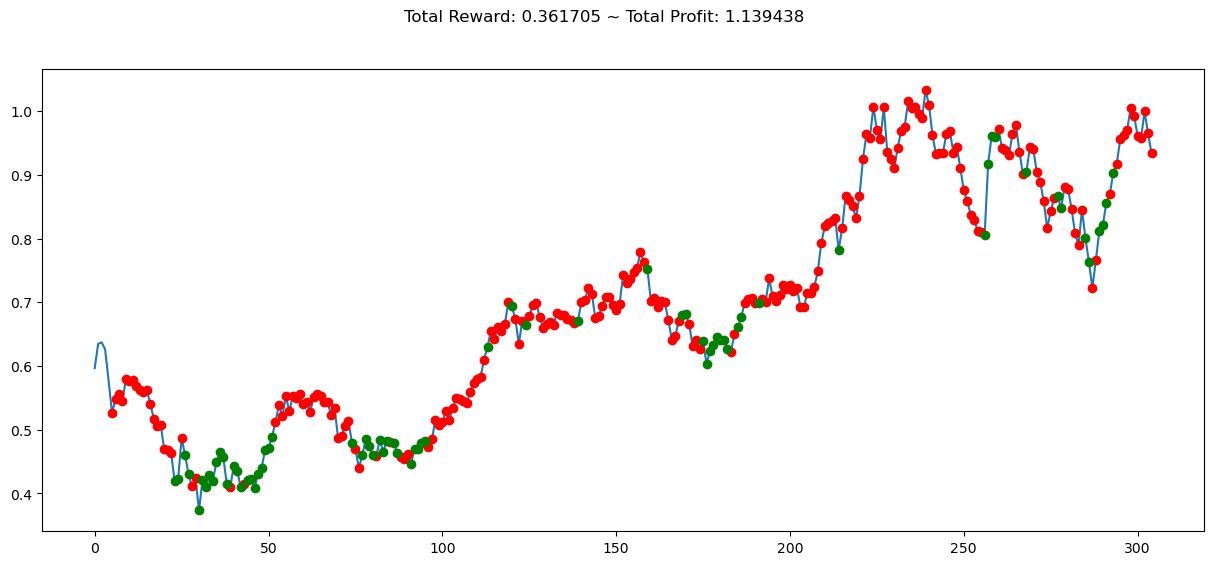

In [18]:
# Model Testing
# Create a new environment with validation data
env = MyCustomEnv(df=RS_data, window_size=5, frame_bound=(1000, 1300))
obs = env.reset()
obs
while True:
    action, _states = Model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

# Plot the results
    
plt.figure(figsize=(15, 6), facecolor='w')
plt.cla()
env.render_all()
plt.show()